In [1]:
from llamba.chat_model import ChatbaseModel, BaseModel
import llamba.plots as bplt
import config

### Initialize a chatbot and test that it works

In [2]:
chatbot = ChatbaseModel(url=config.URL_CB, api_key=config.API_KEY_CB, chatbot_id=config.ID_CB)
res = chatbot.query('What does an increased level of albumin mean?')
print(res)

(True, 'Albumin is a protein found in the blood. An increased level of albumin usually indicates good nutritional status and liver function. It helps maintain fluid balance in the body and contributes to various functions like transporting hormones, vitamins, and drugs.')


### Get a bioage model

In [3]:
from pathlib import Path
import os
import shap
import numpy as np
import pickle
import torch
from txai_omics_3.src.models.tabular.widedeep.ft_transformer import WDFTTransformerModel
from llamba.bioage_model import BioAgeModel

root_dir = Path(os.getcwd()).parent

# Model
fn_model = f"{root_dir}/samples/txai_omics_3/data/immuno/model.ckpt"
model = WDFTTransformerModel.load_from_checkpoint(checkpoint_path=fn_model)
bioage_model = BioAgeModel(model=model)

# SHAP
fn_shap = f"{root_dir}/samples/txai_omics_3/data/immuno/shap.pickle"

def predict_func(x):
    batch = {
        'all': torch.from_numpy(np.float32(x)),
        'continuous': torch.from_numpy(np.float32(x)),
        'categorical': torch.from_numpy(np.int32(x[:, []])),
    }
    return model(batch).cpu().detach().numpy()
with open(fn_shap, 'rb') as handle:
    shap_dict = pickle.load(handle)

h:\Lobachevsky\llamba\llamba_env\Lib\site-packages\lightning_fabric\utilities\cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically upgraded your loaded check

### Load data

In [4]:
import pandas as pd

my_data = {'CXCL9': 2599.629474, 
           'CCL22': 820.306524, 
           'IL6': 0.846377, 
           'PDGFB': 13400.666359, 
           'CD40LG': 1853.847406, 
           'IL27': 1128.886982,
           'VEGFA': 153.574220,
           'CSF1': 239.627236,
           'PDGFA': 1005.844290,
           'CXCL10': 228.229829,
           'Age': 90.454972 }

my_df = pd.DataFrame(my_data, index=[0])

# Model data

train_data = pd.read_excel(f"{root_dir}/samples/txai_omics_3/data/immuno/data.xlsx")

### Initialize a connector

In [5]:
from llamba.connector import Connector

connector = Connector(bioage_model=bioage_model, chat_model=chatbot)

### Run an analysis task

In [6]:
res = connector.analyze(data=my_df, shap_dict=shap_dict)
print(res['analysis'])

You biological age is 55 and your aging acceleration is -35, which means you are ageing slower than normal.

Here is some more information about your data. 

CXCL9: 2599.629474
CXCL9 is a chemokine that mediates inflammatory reactions and is associated with the risk of mortality from cardiovascular diseases. An increased level of CXCL9 can indicate systemic chronic inflammation, which is linked to aging of the cardiovascular system and impaired vascular elasticity.

CD40LG: 1853.847406
Hmm, I am not sure.




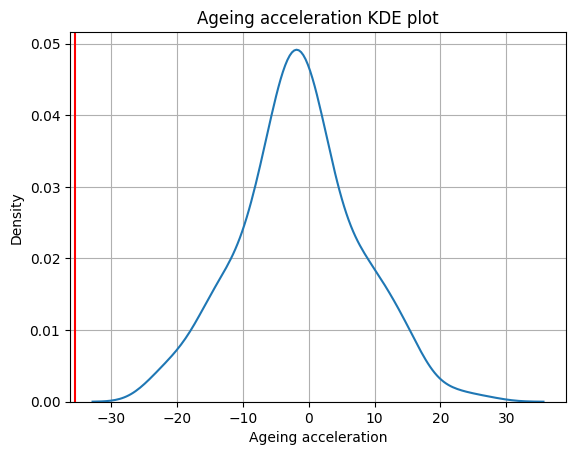

In [7]:
kde = bplt.kde_plot(res['acceleration'], train_data['SImAge acceleration'])

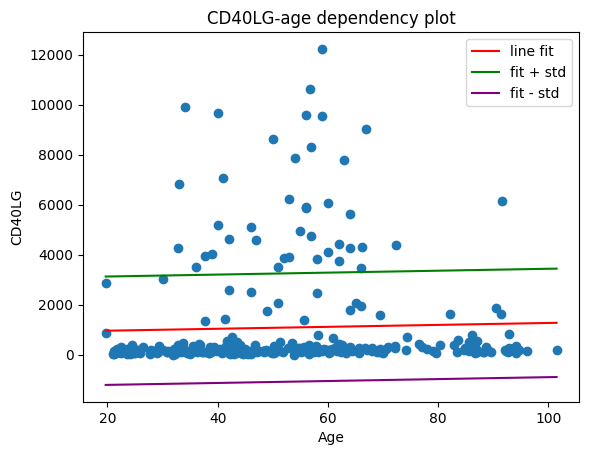

In [8]:
kde = bplt.feat_plot(train_data['CD40LG'], train_data['Age'], res['features'], feat='CD40LG')